In [2]:
import os
import pickle
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "../data"
DATA_FILENAME = "data.csv"
data_file = os.path.join(DATA_PATH, DATA_FILENAME)

In [3]:
iter_csv = pd.read_csv(data_file, encoding="utf-16", sep='\t', iterator=True, chunksize=1000000)
df = pd.concat([chunk[(chunk['Закупки по'] == '44-ФЗ') 
                & (chunk['Этап закупки']=='Определение поставщика завершено')
                & (chunk["Дата обновления"].str.split('.', expand=True).iloc[:, 2].astype("int").isin([2019, 2020, 2021]))] 
                for chunk in tqdm(iter_csv)])

11it [04:23, 24.00s/it]


In [4]:
df['purch'] = df['Реестровый номер закупки'].apply(lambda x: x[1:])
df["Дата обновления"] = pd.to_datetime(df["Дата обновления"], format="%d.%m.%Y")
df["Год обновления"] = df["Дата обновления"].apply(lambda date: date.year)

In [5]:
purch_to_year = df[["purch", "Год обновления"]].reset_index(drop=True).set_index("purch").to_dict()
purch_to_sum = df[["purch", "Начальная (максимальная) цена контракта"]].reset_index(drop=True).set_index("purch").to_dict()

In [6]:
df1 = pd.read_csv(os.path.join(DATA_PATH, "async_info_1.csv"), dtype={"purch": str, "inn": str})
df2 = pd.read_csv(os.path.join(DATA_PATH, "async_info_2.csv"), dtype={"purch": str, "inn": str})
df3 = pd.read_csv(os.path.join(DATA_PATH, "async_info_3.csv"), dtype={"purch": str, "inn": str})
df4 = pd.read_csv(os.path.join(DATA_PATH, "async_info_4.csv"), dtype={"purch": str, "inn": str})
df5 = pd.read_csv(os.path.join(DATA_PATH, "async_info_5.csv"), dtype={"purch": str, "inn": str})
df6 = pd.read_csv(os.path.join(DATA_PATH, "async_info_6.csv"), dtype={"purch": str, "inn": str})
df7 = pd.read_csv(os.path.join(DATA_PATH, "async_info_6.csv"), dtype={"purch": str, "inn": str})
df8 = pd.read_csv(os.path.join(DATA_PATH, "async_info_5.csv"), dtype={"purch": str, "inn": str})
df9 = pd.read_csv(os.path.join(DATA_PATH, "async_info_4.csv"), dtype={"purch": str, "inn": str})
df10 = pd.read_csv(os.path.join(DATA_PATH, "async_info_3.csv"), dtype={"purch": str, "inn": str})
df11 = pd.read_csv(os.path.join(DATA_PATH, "async_info_2.csv"), dtype={"purch": str, "inn": str})
df12 = pd.read_csv(os.path.join(DATA_PATH, "async_info_1.csv"), dtype={"purch": str, "inn": str})

In [7]:
info_df = pd.concat((df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12))

In [8]:
info_df["year"] = info_df["purch"].apply(lambda p: purch_to_year["Год обновления"][p])
info_df["amount"] = info_df["purch"].apply(lambda p: purch_to_sum["Начальная (максимальная) цена контракта"][p])

In [9]:
info_df = info_df[(info_df.inn.notna()) | (info_df.name.notna()) | (info_df.phone.notna())]

In [10]:
info_df.shape

(927660, 8)

In [11]:
count_df = info_df.pivot_table("purch", index="inn", columns=["year"], aggfunc='count')
count_df = count_df.fillna(0)
count_df

year,2019,2020,2021
inn,,,
0000000000,2.0,0.0,0.0
000000000000,10.0,0.0,0.0
010100400827,0.0,2.0,0.0
0101009232,2.0,0.0,2.0
0101009602,2.0,0.0,0.0
...,...,...,...
9909054754,0.0,0.0,2.0
9909156883,0.0,0.0,2.0
9909201656,2.0,0.0,0.0


In [12]:
sum_df = info_df.pivot_table("amount", index="inn", columns=["year"], aggfunc='sum')
sum_df = sum_df.fillna(0)
sum_df

year,2019,2020,2021
inn,,,
0000000000,1.852646e+06,0.00,0.000000e+00
000000000000,1.139978e+07,0.00,0.000000e+00
010100400827,0.000000e+00,8823688.92,0.000000e+00
0101009232,4.678598e+07,0.00,3.169852e+07
0101009602,9.992000e+05,0.00,0.000000e+00
...,...,...,...
9909054754,0.000000e+00,0.00,2.010377e+07
9909156883,0.000000e+00,0.00,3.737616e+08
9909201656,2.923556e+07,0.00,0.000000e+00


In [12]:
count_df = count_df.rename({2019: "Кол-во 2019", 2020: "Кол-во 2020", 2021: "Кол-во 2021"}, axis=1)
sum_df = sum_df.rename({2019: "Сумма 2019", 2020: "Сумма 2020", 2021: "Сумма 2021"}, axis=1)

In [113]:
cond1 = ((sum_df[2020] + sum_df[2021]) / 2)[((((sum_df[2020] + sum_df[2021]) / 2) >= 500000) & (((sum_df[2020] + sum_df[2021]) / 2) <= 3000000))].index

In [136]:
cond2 = count_df[(count_df[2020] != 0) & ((count_df[2021] / count_df[2020]) >= 0.75)].index

In [115]:
cond1

Index(['010100400827', '0101010245', '0101012637', '010101658924',
       '010102380750', '010109940577', '0101980148', '010201137805',
       '0103007142', '010301707174',
       ...
       '9731070183', '9731075583', '9731077140', '9731077340', '9901000411',
       '990100643102', '990100711313', '9901035118', '9901036545',
       '990116467452'],
      dtype='object', name='inn', length=26778)

In [116]:
cond1.intersection(cond2)

Index(['0105004524', '010500595874', '0105051034', '0105069419',
       '010518449747', '0201011980', '0202009729', '020503947633',
       '020702495004', '021700478679',
       ...
       '9723068769', '9724001580', '9725015995', '9725033472', '9729074230',
       '9729289570', '9731004335', '9731012030', '9731046751', '9731050194'],
      dtype='object', name='inn', length=4420)

In [68]:
count_df

year,2019,2020,2021
inn,,,
0000000000,2.0,0.0,0.0
000000000000,10.0,0.0,0.0
010100400827,0.0,2.0,0.0
0101009232,2.0,0.0,2.0
0101009602,2.0,0.0,0.0
...,...,...,...
9909054754,0.0,0.0,2.0
9909156883,0.0,0.0,2.0
9909201656,2.0,0.0,0.0


In [ ]:
values = count_df[(count_df[2020] != 0) & ((count_df[2021] / count_df[2020]) >= 0.75)].index

In [137]:
values = count_df[2021] [count_df[2020] != 0] / count_df[2020][count_df[2020] != 0]

In [13]:
mean_amounts = info_df[info_df.year != 2019].groupby("inn").amount.mean()
#mean_amounts = mean_amounts[(mean_amounts >= 500000) & (mean_amounts <= 30000000)]

In [78]:
cond1 = mean_amounts[(mean_amounts >= 500000) & (mean_amounts <= 3000000)].index

In [82]:
count_df = count_df.loc[cond1]

In [139]:
values

inn
010100400827    0.0
0101010245      0.5
0101012637      0.0
010101658924    0.0
010105665591    0.0
               ... 
9901036545      0.0
9901036552      0.8
990116467452    0.5
990116504915    0.0
990116534780    0.0
Length: 60393, dtype: float64

In [33]:
((mean_amounts >= 500000) & (mean_amounts <= 3000000)).sum()

29309

In [40]:
values = mean_amounts[(mean_amounts >= 500000) & (mean_amounts <= 3000000)]

In [102]:
(values > 0.75).sum()

11056

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [88]:
(values >= 0.75).sum()

4356

In [124]:
mean_amounts.max() / 1000000

135443.82541698

In [130]:
np.arange(10, 150, 20)

array([ 10,  30,  50,  70,  90, 110, 130])

In [132]:
np.concatenate((np.arange(0, 10, 0.25), np.arange(10, 151, 20)))

array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
        10.  ,  30.  ,  50.  ,  70.  ,  90.  , 110.  , 130.  , 150.  ])

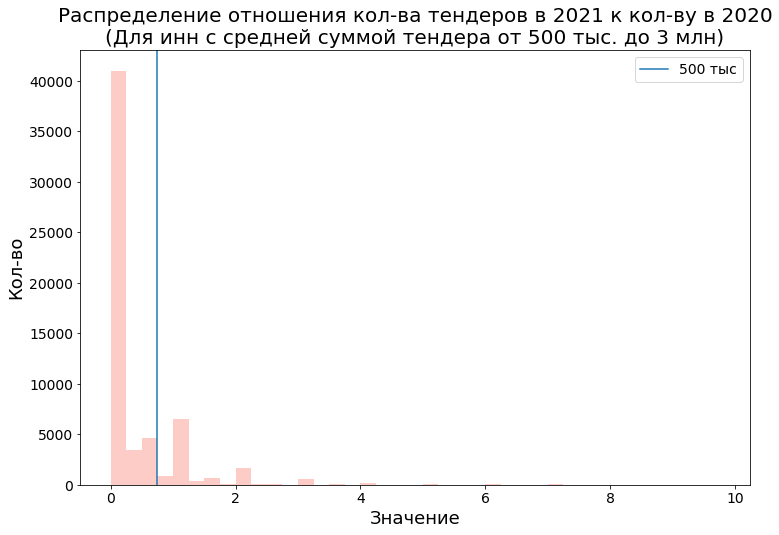

In [141]:
fig, ax = plt.subplots(figsize=(12, 8))

# ax = sns.distplot(mean_amounts / 1000000, color="salmon", \
#                  bins=np.concatenate((np.arange(0, 20, 0.5), np.arange(20, 151, 20))), kde=False, ax=ax)
ax = sns.distplot(values, kde=False, color="salmon", bins=np.arange(0, 10, 0.25), ax=ax)

ax.set_ylabel('Кол-во', fontsize=18)    
ax.set_xlabel('Значение', fontsize=18)
#ax.set_title('Распределение средней суммы тендера за 2020 и 2021 г.', fontsize=20)
ax.axvline(0.75, 0, 1.47, label="500 тыс")
ax.set_title('Распределение отношения кол-ва тендеров в 2021 к кол-ву в 2020\n(Для инн с средней суммой тендера от 500 тыс. до 3 млн)', fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Отношение.jpg", bbox_inches = 'tight')
#plt.savefig("Сумма.jpg", bbox_inches = 'tight')

In [142]:
(values >= 0.75).sum()

11356

In [143]:
(values <= 0.75).sum()

49337

In [144]:
(values == 0.75).sum()

300

In [12]:
cond1 = mean_amounts.index

In [56]:
mean_amounts["773271002265"]

897023.6533333333

In [13]:
info_df = info_df[(info_df.inn.isin(cond1)) & (info_df.inn.isin(cond2))]

In [20]:
info_df = info_df.drop_duplicates(subset=["inn"])

In [25]:
info_df.drop("amount", axis=1, inplace=True)

In [45]:
merged_info_df = info_df.merge(count_df, how="inner", on="inn").merge(sum_df, how="inner", on="inn")

In [52]:
merged_info_df

,purch,inn,name,phone,address,email,Кол-во 2019,Кол-во 2020,Кол-во 2021,Сумма 2019,Сумма 2020,Сумма 2021
0,0373200032219000110,773271002265,ИП Ващенко Виталий АлександровичИндивидуальный...,+7 (915) 129-45-72,"г. Москва, ул. Лукинская, дом 1, кв. 92",vashenkoip@yandex.ru,3.0,1.0,2.0,19878965.48,735912.29,1955158.67
1,0149200002319000054,7813600141,Общество с ограниченной ответственностью «Соци...,+7(812)3808032,"197110, Российская Федерация, г. Санкт-Петербу...",support@social-soft.ru,4.0,2.0,3.0,4669763.00,5008347.00,7146851.00
2,0306200011519000029,6147011500,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ТОРГО...,8-6365-70833,"347810, ОБЛ РОСТОВСКАЯ 61, Г КАМЕНСК-ШАХТИНСКИ...",arix5@rambler.ru,7.0,5.0,6.0,8828845.40,1839990.37,18024308.34
3,0373200041519000080,7715549708,"АНО ""Катаржина""",+7 (499) 205-90-10,"127106 город Москва, улица Комдива Орлова, дом 4",info@katarzyna.ru,1.0,1.0,1.0,3938383.50,1508237.08,349000.01
4,0356500002619000005,5904122072,Федеральное бюджетное учреждение здравоохранен...,7-342-2393409,"614016, КРАЙ ПЕРМСКИЙ, ГОРОД ПЕРМЬ, УЛИЦА КУЙБ...",dogcgepo@bk.ru,3.0,3.0,3.0,959200.34,2195832.40,2544504.92
...,...,...,...,...,...,...,...,...,...,...,...,...
1475,0166100001121000005,7107503225,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОПИ...",7-4872-367591,"300012, ОБЛ ТУЛЬСКАЯ 71, Г ТУЛА, ПР-КТ ЛЕНИНА,...",kmservis71@mail.ru,0.0,1.0,1.0,0.00,750000.00,1050000.00
1476,0873100007321000019,9718118661,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЭКОВ...",7-967-0498708,"107497, Г МОСКВА 77, ПРОЕЗД 2-Й ИРТЫШСКИЙ, ДОМ...",ecovelikan@gmail.ru,0.0,1.0,1.0,0.00,15120753.90,14191200.00
1477,0122200002521003697,2723003367,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ПРЕДП...,79142035972,"680020, КРАЙ ХАБАРОВСКИЙ 27, Г ХАБАРОВСК, ПЕР ...",izotop@bk.ru,0.0,1.0,1.0,0.00,5931999.96,88537.08
1478,0190200000320012257,781418325084,КУРИЛЕНКО АНАТОЛИЙ ВАЛЕРЬЕВИЧ -Индивидуальный ...,7-812-7035355,"Г САНКТ-ПЕТЕРБУРГ78,",medkontakt@medkontakt.spb.ru,0.0,1.0,1.0,0.00,1024920.00,1210000.00


In [49]:
merged_info_df.to_excel(os.path.join(DATA_PATH, "info.xlsx"), index=False)